In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import functools
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
import time
import warnings
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/trainData.csv', header=None).values
train_label = pd.read_csv('/content/drive/My Drive/trainLabels.csv', header=None).values
test_data = pd.read_csv('/content/drive/My Drive/testData.csv', header=None).values
test_label = pd.read_csv('/content/drive/My Drive/testLabels.csv', header=None).values

In [ ]:
def get_accuracy(pred, true):
    s=0
    for ind, elem in enumerate(true):
        if elem == pred[ind]:
            s+=1
    return s/len(true)

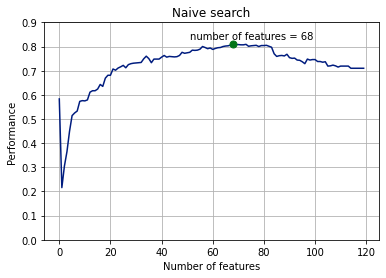

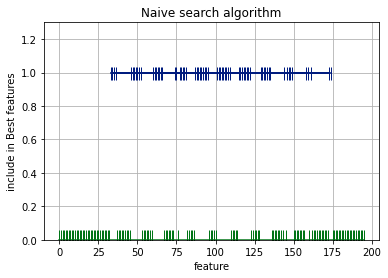

elapsed time: 80.1451165676117s


In [ ]:
warnings.filterwarnings('ignore')
# Naive search

class NaiveSearch(object):
    def __init__(self, X, y, num_of_features):
        self.train_data, self.test_data, self.train_label, self.test_label = train_test_split(X, y, test_size=0.2)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train_data, self.train_label, test_size=0.2)
        
        self.num_of_features = num_of_features
        self.best_scores = []
        self.features_log = []
        self.clf = GaussianNB()
        self.features = np.arange(X.shape[1])
        self.time_elapsed  = 0
        self.best_set_of_features = []
        if X.shape[1] < num_of_features:
            raise ValueError(f"invalid input: '{num_of_features}'")
        
        
    def launch(self):
        t_0 = time.time()        
        for i in range(self.num_of_features):
            scores = []
            for n in self.features:
                y_pred = self.clf.fit(self.X_train[:, n].reshape(-1,1), 
                  self.y_train.ravel()).predict(self.X_test[:, n].reshape(-1,1))
                scores.append(get_accuracy(y_pred, self.y_test))
            best_features = np.argsort(scores)[-i:]
            
            y_pred = self.clf.fit(self.train_data[:, best_features], 
                 self.train_label.ravel()).predict(self.test_data[:, best_features])             
            score = get_accuracy(y_pred, self.test_label)
            self.best_scores.append(score)
            self.features_log.append(best_features)
        self.time_elapsed = time.time()-t_0
        
        self.best_set_of_features = self.features_log[np.argmax(self.best_scores)]
        return self.best_set_of_features
            
            
    def plot_ns(self):
        %matplotlib inline
        plt.style.use('seaborn-dark-palette')
        plt.plot(self.features[:self.num_of_features], self.best_scores)
        plt.xlabel('Number of features')
        plt.ylabel('Performance')
        plt.title('Naive search')
        plt.grid(True)
        idx = len(self.best_set_of_features)
        plt.plot(idx, np.max(self.best_scores), marker='o', markersize=7)
        plt.annotate(f'number of features = {idx}', (idx-17, np.max(self.best_scores)+0.02))
        plt.ylim((0, 0.9))
        plt.show()

        plt.plot(self.best_set_of_features, np.ones(len(self.best_set_of_features)), marker='|', markersize=13)
        useless_feature = list(set(self.features) -  set(self.best_set_of_features))
        plt.plot(useless_feature, np.zeros(len(useless_feature)), marker='|', markersize=20)
        plt.ylim((0, 1.3))
        plt.xlabel('feature')
        plt.ylabel('include in Best features')
        plt.title('Naive search algorithm')
        plt.grid(True)
        plt.show()
        print(f"elapsed time: {self.time_elapsed}s")

NS = NaiveSearch(train_data, train_label, 120)
best_features = NS.launch()
NS.plot_ns()

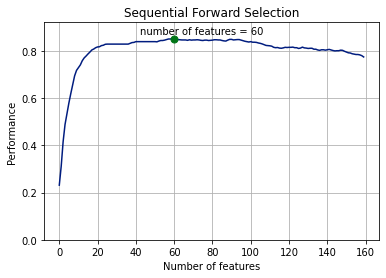

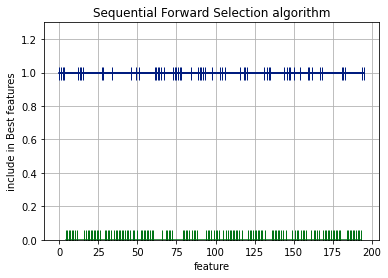

elapsed time: 261.0545189380646s


In [ ]:
# SFS

class SFS(object):
    def __init__(self, X, y, num_of_features):

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25)
        self.num_of_features = num_of_features
        self.best_scores = []
        self.features = np.arange(X.shape[1])
        self.best_set_of_features = []
        self.time_elapsed  = 0
        self.clf = GaussianNB()
        self.selected_features = []
        self.remained_features = list(self.features)
        self.features_log = []
        if X.shape[1] < num_of_features:
            raise ValueError(f"invalid input: '{num_of_features}'")



    def launch(self):
        t_0 = time.time()
        for i in range(self.num_of_features):
            scores = []
            for n in self.remained_features:
                curr_f =  list(set(self.selected_features))+list([n])
                y_pred = self.clf.fit(self.X_train[:, curr_f], 
                      self.y_train.ravel()).predict(self.X_test[:, curr_f])
                scores.append(get_accuracy(y_pred, self.y_test))
            best_feature = self.remained_features[np.argmax(scores)]
            self.selected_features.append(best_feature)
            self.remained_features.remove(best_feature)
            self.best_scores.append(np.max(scores))
            self.features_log.append(self.selected_features.copy())
        self.time_elapsed  = time.time()-t_0
        self.best_set_of_features = self.features_log[np.argmax(self.best_scores)]
        return self.best_set_of_features

        
        
    def plot_sfs(self):
        %matplotlib inline
        plt.style.use('seaborn-dark-palette')
        plt.plot(self.features[:self.num_of_features], self.best_scores)
        plt.xlabel('Number of features')
        plt.ylabel('Performance')
        plt.title('Sequential Forward Selection')
        plt.grid(True)
        idx = len(self.best_set_of_features)
        plt.plot(idx, np.max(self.best_scores), marker='o', markersize=7)
        plt.annotate(f'number of features = {idx}', (idx-18, np.max(self.best_scores)+0.02))
        plt.ylim((0, 0.92))
        plt.show()

        plt.plot(self.best_set_of_features, np.ones(len(self.best_set_of_features)), marker='|', markersize=13)
        useless_feature = list(set(self.features) -  set(self.best_set_of_features))
        plt.plot(useless_feature, np.zeros(len(useless_feature)), marker='|', markersize=20)
        plt.ylim((0, 1.3))
        plt.xlabel('feature')
        plt.ylabel('include in Best features')
        plt.title('Sequential Forward Selection algorithm')
        plt.grid(True)
        plt.show()
        print(f"elapsed time: {self.time_elapsed}s")


sfs = SFS(train_data, train_label, 160)
best_features = sfs.launch()
sfs.plot_sfs()

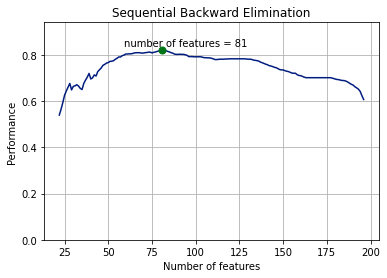

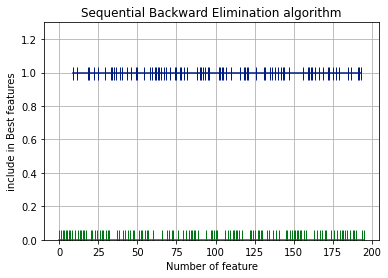

elapsed time: 428.0098807811737s


In [ ]:
#SBE

class SBE(object):
    def __init__(self, X, y, num_of_features):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25)
        self.num_of_features = num_of_features
        self.best_scores = []
        self.features = np.arange(X.shape[1])
        self.best_set_of_features = []
        self.time_elapsed  = 0
        self.clf = GaussianNB()
        self.remained_features = list(self.features)
        self.features_log = []
        if X.shape[1] < num_of_features:
            raise ValueError(f"invalid input: '{num_of_features}'")


    def launch(self):
        t_0 = time.time()
        for i in range(self.num_of_features):
            scores = []
            for n in self.remained_features:
                curr_f = self.remained_features.copy()
                curr_f.remove(n)
                y_pred = self.clf.fit(self.X_train[:, curr_f], self.y_train.ravel()).predict(self.X_test[:, curr_f])
                scores.append(get_accuracy(y_pred, self.y_test))
            worst_feature = self.remained_features[np.argmax(scores)]
            self.remained_features.remove(worst_feature)
            self.best_scores.append(np.max(scores))
            self.features_log.append(self.remained_features.copy())
        self.best_set_of_features = self.features_log[np.argmax(self.best_scores)]
        self.time_elapsed  = time.time()-t_0
        return self.best_set_of_features

    
    
    def plot_sbe(self):
        plt.style.use('seaborn-dark-palette')
        l = list(len(self.features)- self.features[:self.num_of_features])
        plt.plot(l, self.best_scores)
        plt.xlabel('Number of features')
        plt.ylabel('Performance')
        plt.title('Sequential Backward Elimination')
        plt.grid(True)
        idx = len(self.best_set_of_features)
        plt.plot(idx, np.max(self.best_scores), marker='o', markersize=7)
        plt.annotate(f'number of features = {idx}', (idx-22, np.max(self.best_scores)+0.02))
        plt.ylim((0, 0.94))
        plt.show()

        plt.plot(self.best_set_of_features, np.ones(len(self.best_set_of_features)), marker='|', markersize=13)
        useless_feature = list(set(self.features) -  set(self.best_set_of_features))
        plt.plot(useless_feature, np.zeros(len(useless_feature)), marker='|', markersize=20)
        plt.ylim((0, 1.3))
        plt.xlabel('Number of feature')
        plt.ylabel('include in Best features')
        plt.title('Sequential Backward Elimination algorithm')
        plt.grid(True)
        plt.show()    
        print(f"elapsed time: {self.time_elapsed}s")
        
sbe = SBE(train_data, train_label, 175)
best_features = sbe.launch()
sbe.plot_sbe()     

In [1]:
# SFFS

class SFFS(object):
    def __init__(self, X, y, num_of_features):

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25)
        self.num_of_features = num_of_features
        self.best_scores = []
        self.features = np.arange(X.shape[1])
        self.best_set_of_features = []
        self.time_elapsed  = 0
        self.clf = GaussianNB()
        self.selected_features = []
        self.remained_features = list(self.features)
        self.eliminated_features = []
        self.features_log = []
        if X.shape[1] < num_of_features:
            raise ValueError(f"invalid input: '{num_of_features}'")



    def launch(self):
        t_0 = time.time()
        for i in range(self.num_of_features):
            scores = []
            for n in self.remained_features:
                curr_f =  list(set(self.selected_features))+list([n])
                y_pred = self.clf.fit(self.X_train[:, curr_f], 
                      self.y_train.ravel()).predict(self.X_test[:, curr_f])
                scores.append(get_accuracy(y_pred, self.y_test))
            best_feature = self.remained_features[np.argmax(scores)]
            self.selected_features.append(best_feature)
            self.remained_features.remove(best_feature)
            self.best_scores.append(np.max(scores))
            
            while len(self.selected_features) > 2:
                sbe_scores = []
                for sf in self.selected_features:
                    curr_f = self.selected_features.copy()
                    curr_f.remove(sf)
                    y_pred = self.clf.fit(self.X_train[:, curr_f], self.y_train.ravel()).predict(self.X_test[:, curr_f])
                    sbe_scores.append(get_accuracy(y_pred, self.y_test))
                if np.max(sbe_scores) >= np.max(scores):
                    worst_feature = self.selected_features[np.argmax(sbe_scores)]
                    self.selected_features.remove(worst_feature)
                    self.remained_features.append(worst_feature)
                    self.best_scores.pop()
                    self.best_scores.append(np.max(sbe_scores))
                else:
                    break

            self.features_log.append(self.selected_features.copy())
        self.time_elapsed  = time.time()-t_0
        self.best_set_of_features = self.features_log[np.argmax(self.best_scores)]
        return self.best_set_of_features

        
        
    def plot_sffs(self):
        plt.style.use('seaborn-dark-palette')
        plt.plot(self.features[:self.num_of_features], self.best_scores)
        plt.xlabel('Number of features')
        plt.ylabel('Performance')
        plt.title('Sequential Forward Selection')
        plt.grid(True)
        idx = len(self.best_set_of_features)
        plt.plot(idx, np.max(self.best_scores), marker='o', markersize=10)
        plt.annotate(f'number of features = {idx}', (idx-15, np.max(self.best_scores)+0.02))
        plt.ylim((0, 0.9))
        plt.show()

        z = [len(l) for l in self.features_log]
        plt.plot(sffs.features[:self.num_of_features], z)
        plt.xlabel('iteration')
        plt.ylabel('number of features')
        plt.title('Sequential Forward Selection algorithm')
        plt.grid(True)
        plt.show()
        print(f"elapsed time: {self.time_elapsed}s")

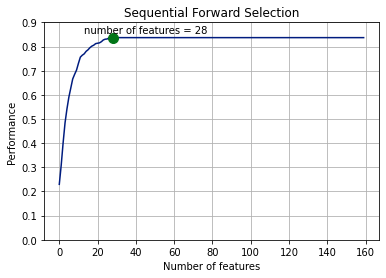

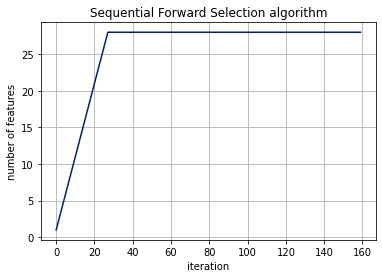

elapsed time: 298.2728023529053s


In [ ]:
sffs = SFFS(train_data, train_label, 160)
best_features = sffs.launch()   
sffs.plot_sffs()